In [168]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## 1) Преобразуйте данные:
### a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;
### b. закодируйте категориальные переменные числовыми значениями по необходимости.

In [169]:
data = pd.read_csv('athletes.csv')

In [170]:
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [171]:
data = data[ pd.isnull( data['height'] ) == 0 ]
data = data[ pd.isnull( data['weight'] ) == 0 ]

In [172]:
X = data[['height', 'weight', 'gold', 'silver', 'bronze']]
X.head(3)

,height,weight,gold,silver,bronze
0,1.72,64.0,0,0,0
1,1.68,56.0,0,0,0
2,1.98,79.0,0,0,1


In [173]:
le = LabelEncoder()
le.fit( data['sex'] )
y = pd.Series( data = le.transform( data['sex'] ) )
y.head()

0    1
1    0
2    1
3    1
4    1
dtype: int32

## 2) Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.

In [174]:
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model.fit(X_train, y_train)

LogisticRegression()

## 3) Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.

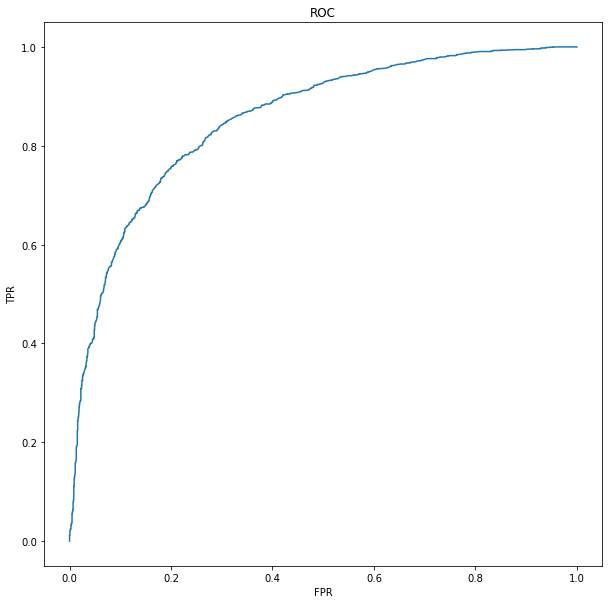

In [175]:
predictions = model.predict_proba(X_test)
fpr, tpr, thres = roc_curve( y_test, predictions[:, 1])
plt.figure(figsize=(10, 10))
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot( fpr, tpr )

## 4) Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

In [176]:
roc_auc_score(y_test, predictions[:, 1])

0.8542161334188973

## 5) Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.
### Я не стал создавать функцию для вычисления непосредственно tpr и fpr, так как для рассчётов в остальных пунктах нужны более примитивные данные типа tp, fp, tn, fn. Всё остальное вычисляется в процессе реализации более сложных задач

In [177]:
def metricks(pr, yt):
    ans = [0, 0, 0, 0] #tp, fp, tn, fn
    for i in range(len(yt)):
        if pr[i] == 1:
            if yt[i] == 1:
                ans[0] += 1
            else:
                ans[1] += 1
        else:
            if yt[i] == 1:
                ans[3] += 1
            else:
                ans[2] += 1
    return ans

In [178]:
y_test1 = y_test.to_numpy()
met = metricks(model.predict(X_test), y_test1)
met

[1419, 326, 1114, 399]

In [179]:
def roc_curve1(yt, pr):
    fpr = []
    tpr = []
    cl = np.arange(len(pr))
    porog = np.linspace( 0, 1, 1000 )
    yt = yt.to_numpy()
    for i in range(1000):
        for j in range(len(pr)):
            if pr[j] > porog[-i - 1]:
                cl[j] = 1
            else:
                cl[j] = 0
        ans = metricks(cl, yt)
        fpr.append(ans[1] / (ans[1] + ans[2]))
        tpr.append(ans[0] / (ans[0] + ans[3]))
    return tpr, fpr

## 6) Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

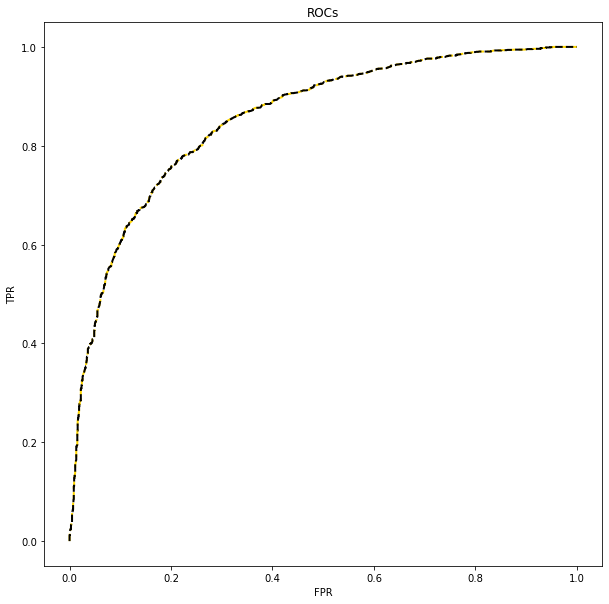

In [180]:
tpr1, fpr1 = roc_curve1(y_test, model.predict_proba(X_test)[ : , 1])
plt.figure(figsize=(10, 10))
plt.title("ROCs")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr1, tpr1, c = 'gold', linestyle='--', linewidth = 2)
plt.plot(fpr, tpr, c = 'black', linestyle='--', linewidth = 2)
plt.show()

### При помощи наложения двух графиков друг на друга видно, что работа проделана без ошибок, так как самодельная ROC кривая почти полностью совпадает с ROC кривой, реализованной с помощью SkLearn'a. Есть небольшие отличия, но это скорее всего вызвано различием в количестве итераций(пороговых значений), что не суть важно. 

## 7) Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.

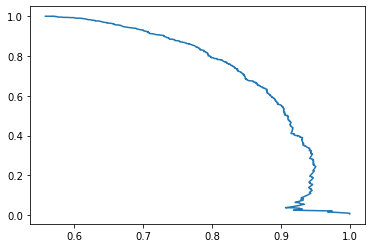

In [181]:
def pr(yt, pr):
    precision = []
    recall = []
    cl = np.arange(len(pr))
    porog = np.linspace( 0, 1, 1000 )
    yt = yt.to_numpy()
    for i in range(1000):
        for j in range(len(pr)):
            if pr[j] > porog[-i - 1]:
                cl[j] = 1
            else:
                cl[j] = 0
        ans = metricks(cl, yt)
        if (ans[0] + ans[1] != 0) and (ans[0] + ans[3] != 0):
            precision.append(ans[0] / (ans[0] + ans[1]))
            recall.append(ans[0] / (ans[0] + ans[3]))
    return precision, recall
precision1, recall1 = pr(y_test, model.predict_proba(X_test)[ : , 1])
plt.plot(precision1, recall1)

## 8) *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

In [182]:
def auc1(yt, pr):
    total = 0
    tpr, fpr = roc_curve1(yt, pr)
    for i in range(1, len(tpr)):
        if tpr[i] == tpr[i - 1]:
            total += tpr[i] * (fpr[i] - fpr[i - 1])
        elif tpr[i] > tpr[i - 1]:
            total += (tpr[i - 1] + 0.5 * (tpr[i] - tpr[i - 1])) * (fpr[i] - fpr[i - 1])
        else:
            total += (tpr[i - 1] - 0.5 * (tpr[i] - tpr[i - 1])) * (fpr[i] - fpr[i - 1])
    return total

In [183]:
auc1(y_test, predictions[:, 1])

0.8542119316098276